In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
# import tensorflow as tf
from scripts.iab import AttPredictorPecNet, AttPredictorPecNetWithType, AttPredictorPecNetWithTypeD3
from scripts.visualize import vis_cur_and_fut
from scripts.config import build_parser
from scripts.dataloaders import context_description, CustomImageDataset, d_collate_fn
from scripts.rgb_loader import RgbLoader

# tf.get_logger().setLevel('ERROR')

import torch

from tqdm.auto import tqdm
import torch.utils.data

import matplotlib.pyplot as plt
import numpy as np
import wandb
import random
from scripts.train import preprocess_batch, apply_tr, get_future

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

import os
from scripts.iab_pl import AttPredictorPecNetWithTypeD3
from scripts.visualize import visualize_one_step_with_future, vis_cur_and_fut

In [2]:
class Config:
    def __init__(self):
        self.exp_use_points = 0
        self.exp_use_vis = 1
        self.exp_embed_dim = 256
        self.exp_use_rec = 0
        self.exp_inp_dim = 128
        self.exp_num_blocks = 4
        self.exp_lr = 1e-5
        self.exp_batch_size = 1
        self.dir_data = "/home/jovyan/uncompressed/tf_example"
        self.exp_num_workers = 0
config = Config()

In [3]:
import pathlib
from read_map_ds import WaymoDataset

In [4]:
# model = AttPredictorPecNetWithTypeD3(config=config, wandb_logger=None)

ds_path = config.dir_data
assert pathlib.Path(ds_path).exists()

index_file = "training_mapstyle/index_file.txt"
index_file = pathlib.Path(ds_path) / index_file
train_dataset = WaymoDataset(ds_path, index_file, rgb_index_path="/home/jovyan/rendered/train/index.pkl", rgb_prefix="/home/jovyan/")


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.exp_batch_size,
                                           num_workers=config.exp_num_workers, collate_fn=d_collate_fn)


loaded index file contains 11940.0 indexes to files


In [5]:
it = iter(train_loader)

In [6]:
data = next(it)

In [7]:
[data.keys()]

[dict_keys(['state/current/x', 'state/current/y', 'state/past/x', 'state/past/y', 'state/current/velocity_x', 'state/current/velocity_y', 'state/future/x', 'state/future/y', 'state/future/valid', 'state/current/valid', 'state/past/valid', 'state/tracks_to_predict', 'roadgraph_samples/xyz', 'roadgraph_samples/id', 'roadgraph_samples/type', 'roadgraph_samples/valid', 'scenario/id', 'state/past/vel_yaw', 'state/current/vel_yaw', 'state/past/bbox_yaw', 'state/current/bbox_yaw', 'state/id', 'state/type', 'traffic_light_state/current/valid', 'state/current/width', 'state/current/length', 'traffic_light_state/current/state', 'rgbs', 'file'])]

In [8]:
print(data["scenario/id"].numpy().tobytes())

# print(data["state/id"])
print((data["state/tracks_to_predict"]>0).nonzero())
print(data["state/id"][data["state/tracks_to_predict"]>0])

print(data["state/current/bbox_yaw"][0,0])

b'f30f32c55238a080'
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7]])
tensor([ 21.,  31.,  79.,  83.,  91.,  93., 162., 212.])
tensor(-2.6875)


In [9]:
size_pixels=224
import uuid
def fig_canvas_image(fig):
    """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
    # Just enough margin in the figure to display xticks and yticks.
    fig.subplots_adjust(
        left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def create_figure_and_axes(size_pixels):
    """Initializes a unique figure and axes for plotting."""
    fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

    # Sets output image to pixel resolution.
    dpi = 100
    size_inches = size_pixels / dpi
    fig.set_size_inches([size_inches, size_inches])
    fig.set_dpi(dpi)
    fig.set_facecolor('white')
    ax.set_facecolor('white')
    ax.xaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='y', colors='black')
    fig.set_tight_layout(True)
    ax.grid(False)
    ax.set_axis_off()
    ax.margins(x=0, y=0, tight=True)
    return fig, ax

def plot_scene_my(data, ag_id):
    fig, ax = create_figure_and_axes(size_pixels=size_pixels)
    yaw = data["state/current/bbox_yaw"][0,ag_id]
    rot_matrix = np.array(
                    [
                        [np.cos(yaw), -np.sin(yaw)],
                        [np.sin(yaw), np.cos(yaw)],
                    ]
                )
    hist = np.stack([data['state/past/x'].reshape(128,10), data['state/past/y'].reshape(128,10)], axis=-1)
    cur = np.stack([data['state/current/x'].reshape(128), data['state/current/y'].reshape(128)], -1)
    state = np.concatenate([hist, cur.reshape(128,1,2)], 1)
    state = np.flip(state, 1)
    #fut = np.stack([data['state/future/x'].reshape(128,80)[ag_id], data['state/future/y'].reshape(128,80)[ag_id]], axis=-1)
    hist_start = state[ag_id][0]
    pix_to_m = 224 / 40
    shift_meters = np.array([224//6, 224//2])
    is_valid = np.concatenate([data['state/past/valid'].reshape(128,10), data['state/current/valid'].reshape(128,1)], -1)
    is_valid = np.flip(is_valid, 1)
    is_fut = data['state/future/valid'].reshape(128,80)[ag_id]#.reshape(80,1)
    
    agent_is_valid = is_valid[ag_id]#.reshape(11,1)
    hist_img = ((state[ag_id] - hist_start)[agent_is_valid>0])  @ rot_matrix * pix_to_m + shift_meters
    # fut_img = ((fut - hist_start)[is_fut>0]) @ rot_matrix * pix_to_m + shift_meters
    
    xy_lines = (data["roadgraph_samples/xyz"].reshape(20000, 3)[:,:2]  - hist_start) @ rot_matrix * pix_to_m + shift_meters
    others_img = (state - hist_start) @ rot_matrix * pix_to_m + shift_meters
    
    
    for i in range(11):
        ax.plot(others_img[:, i, 0], others_img[:,i, 1], "*g", markersize=4-(i*0.3),  alpha= 1 - i/20)
    
#     print(((state[ag_id] - hist_start))  @ rot_matrix * pix_to_m + shift_meters)
    
    for i in range(len(hist_img)-1):
        ax.plot(hist_img[:i+2,0][i:], hist_img[:i+2:,1][i:], "b", linewidth=6,  alpha=1 - i/13)
    # ax.plot(fut_img[:,0], fut_img[:,1], "r")


    ax.plot(xy_lines[:, 0], xy_lines[:,1], "ok", markersize=2.0)
    ax.plot(xy_lines[:, 0], xy_lines[:,1], "*k", markersize=1.)
    plt.xlim(0, 224)
    plt.ylim(0, 224)
    image = fig_canvas_image(fig)
    plt.close(fig)
    return image

(224, 224, 3)

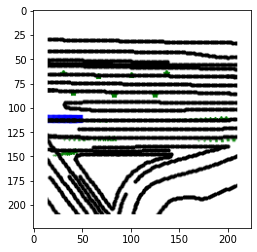

In [14]:
image = plot_scene_my(data, 3)
plt.imshow(image)
image.shape

In [11]:
# image = plot_scene_my(data, 5)

# plt.imshow(image)

for i in (data["state/tracks_to_predict"]>0).nonzero():
    sid = data["scenario/id"].numpy().tobytes().decode("utf-8")
    aid = data["state/id"][0][i[1]]
    
    img = plot_scene_my(data, i[1])
    print(f"sidaid {str(sid)+str(float(aid))}")
    

sidaid f30f32c55238a08021.0
sidaid f30f32c55238a08031.0
sidaid f30f32c55238a08079.0
sidaid f30f32c55238a08083.0
sidaid f30f32c55238a08091.0
sidaid f30f32c55238a08093.0
sidaid f30f32c55238a080162.0
sidaid f30f32c55238a080212.0


In [ ]:
# # inp
# data = [1,2,3,4,5]
# def f(x):
#     return x**2

# # processing (multiprocessing)
# with Pool(os.cpu_count()-2) as p:
#     result = p.map(f, data)

# # out
# print(result) # [1,4,9,16,25]

In [53]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.exp_batch_size,
#                                            num_workers=config.exp_num_workers, collate_fn=d_collate_fn)
import math

lnsp =np.linspace(start=0, stop=len(train_dataset), num=12)
dss = []
for i in range(1,len(lnsp)):
    print(math.ceil(lnsp[i-1]), math.ceil(lnsp[i]))
    ds = torch.utils.data.Subset(train_dataset, range(math.ceil(lnsp[i-1]), math.ceil(lnsp[i])))
    dss.append(ds)
s = 0
for ds in dss:
    s+= len(ds)

print(s)
print(len(train_dataset))

0 39747
39747 79494
79494 119241
119241 158987
158987 198734
198734 238481
238481 278228
278228 317974
317974 357721
357721 397468
397468 437214
437214
437214


In [ ]:
# from multiprocessing import Pool
# def test(i):
#     print(i)
#     sid = data["scenario/id"].numpy().tobytes().decode("utf-8")
#     aid = data["state/id"][0][i[1]]
#     name = str(sid)+str(float(aid))
# #     img = plot_scene_my(data, i[1])[np.newaxis]
#     print(name)
#     return name#, img] 

# # for i in (data["state/tracks_to_predict"]>0).nonzero()
# with Pool(os.cpu_count()-2) as p:
#     result = p.map(test, (data["state/tracks_to_predict"]>0).nonzero())

In [57]:
import glob
import pickle
import multiprocessing

def create_raster(data):
                rgb_d = {}
                for i in (data["state/tracks_to_predict"]>0).nonzero():
                    sid = data["scenario/id"].numpy().tobytes().decode("utf-8")
                    aid = data["state/id"][0][i[1]]
                    name = str(sid)+str(float(aid))
                    img = plot_scene_my(data, i[1])[np.newaxis]
                    rgb_d[name] = img
                return name, img

class RgbRendererMy:
    def __init__(self, index_path="renderedMy40/index.pkl", rgb_file_name_base="renderedMy40/rgb", train_loader=None):
        self.index_path = index_path
        self.rgb_file_name_base = rgb_file_name_base
        self.train_loader = train_loader

    def save_dict(self, di_, filename_=None):
        if filename_ is None:
            filename_ = self.index_path
        with open(filename_, 'ab') as f:
            pickle.dump(di_, f)

    def save_dataset(self, train_loader=None, index_file_name=None, rgb_file_name_base=None, rgb_file_name_index=None):
        
        if not train_loader:
            train_loader=self.train_loader
        if index_file_name is None:
            index_file_name = self.index_path
        if rgb_file_name_base is None:
            rgb_file_name_base = self.rgb_file_name_base
        
        if not rgb_file_name_index:
            rgb_file_name_index = len(glob.glob(self.rgb_file_name_base+"*"))
        print(f" staring index {rgb_file_name_index}")
        rgb_holder = {}

        index_dict = {}

        tli = iter(train_loader)
        for data in tqdm(tli):
            file_index = rgb_file_name_base + str(rgb_file_name_index) + ".npz"            
            name, img = create_raster(data)            
            d = {name: file_index}

            index_dict = {**d, **index_dict}

            rgb_holder = {**rgb_holder, **{name: img}}
            if len(rgb_holder) >= 200:
                np.savez_compressed(rgb_file_name_base + str(rgb_file_name_index), rgb=rgb_holder,
                         names=np.array(list(index_dict.keys())))
                rgb_file_name_index += 1
                rgb_holder = {}
                self.save_dict(index_dict, index_file_name)
                index_dict = {}
        self.save_dict(index_dict, index_file_name)
        np.savez_compressed(rgb_file_name_base + str(rgb_file_name_index), rgb=rgb_holder, names=np.array(list(index_dict.keys())))
        return


In [67]:
# rends

In [71]:
for i in :
    print (i[1])

10000000.0
20000000.0
30000000.0
40000000.0
50000000.0
60000000.0
70000000.0
80000000.0
90000000.0
100000000.0
110000000.0


In [72]:
lnsp =np.linspace(start=0, stop=len(train_dataset), num=12)
dls = []
rends = []
indexes = []

for i in range(1,len(lnsp)):
    print(math.ceil(lnsp[i-1]), math.ceil(lnsp[i]))
    ds = torch.utils.data.Subset(train_dataset, range(math.ceil(lnsp[i-1]), math.ceil(lnsp[i])))
    dl = torch.utils.data.DataLoader(ds, batch_size=config.exp_batch_size,
                                           num_workers=config.exp_num_workers, collate_fn=d_collate_fn)
    
    rend = RgbRendererMy(index_path=f"renderedMy40/index+{i}.pkl", train_loader=train_loader) #rgb_file_name_index=
    rends.append(rend)
    indexes.append(f"{i*1e7}")
    dls.append(dl)
s = 0

def st(inp):
    rend, rgb_file_name_index = inp
    print(rend)
    # rend.save_dataset(rgb_file_name_index=rgb_file_name_index)
    
with multiprocessing.Pool(12) as p:
     result = p.map(st, zip(rends, indexes))        







0 39747
39747 79494
79494 119241
119241 158987
158987 198734
198734 238481
238481 278228
278228 317974
317974 357721
357721 397468
397468 437214


In [63]:
# print(1)

In [ ]:
rgBloader_my40 = RgbLoader(index_path="/media/robot/hdd/waymo-open-dataset-repo/tutorial/renderedMy40/index.pkl")
train_index_path = "./rendered/train/index.pkl"
train_rgb_loader = RgbLoader(train_index_path)


In [ ]:
it = iter(train_loader)
data = next(it)

In [ ]:
plt.imshow(train_rgb_loader.load_batch_rgb(data, prefix="./")[3])

In [ ]:
plt.imshow(rgBloader_my40.load_batch_rgb(data, prefix="./")[3])

In [ ]:
# # visualize_one_step_with_future
# s = current_states
# m = current_states_mask
# visualize_one_step_with_future(s[:, 0], m[:, 0], future_states, future_states_mask, roadgraph_xyz,
#                             'cur with fut', center_y, center_x, width, color_map, size_pixels,
#                                         predictions=prediction, confs=confs)

from matplotlib.pyplot import figure

figure(figsize=(8*2, 6*2), dpi=80)()

plt.imshow(vis_cur_and_fut(next(it)))

In [ ]:
def vis_rgb(ag_id, data_ind):
#     ag_id = 1
    data = train_dataset[data_ind]
    future = np.stack([data['state/future/x'].reshape(128,80)[ag_id], data['state/future/y'].reshape(128,80)[ag_id]], axis=-1)
    # future -= future[0]
    yaw = data["state/current/bbox_yaw"][ag_id]
    rot_matrix = np.array(
                [
                    [np.cos(yaw), -np.sin(yaw)],
                    [np.sin(yaw), np.cos(yaw)],
                ]
            )
    m_to_pix = 224/160

    shift = 512
    magic_const=3
    raster_size=224
    crop_size=224
    displacement = np.array([[raster_size // 2, raster_size // 4]]) * shift
    displacement = np.array([[raster_size // 4, raster_size // 2]])
    # center_xy = future[0] * shift * magic_const * raster_size / crop_size
    # centered_others = (future.reshape(-1, 2) * shift * magic_const * raster_size / crop_size - center_xy
    #                           ) @ rot_matrix #+ displacement
    center_xy = future[0]
    centered_others = (future.reshape(-1, 2) - center_xy
                              ) @ rot_matrix
    # displacement
    poses_pix = (centered_others * m_to_pix + displacement).astype(int)
    #[poses_pix]
    im_copy = np.copy(data["rgbs"][0,ag_id])
    print(im_copy.shape)
    for i, point in enumerate(poses_pix):
        if data["state/future/valid"].reshape(128,80)[ag_id, i]:
            im_copy[point[1],point[0],:]  = [70,0,70]
            im_copy[point[1]-1,point[0],:]  = [70,0,70]
        pass
    from matplotlib.pyplot import figure

    figure(figsize=(8*2, 6*2), dpi=80)
    plt.imshow(im_copy)

In [ ]:
vis_rgb(0, 8)

In [ ]:
from scripts.rasterization import rasterize

In [ ]:
rasterize(tracks_to_predict, past_x, past_y, current_x, current_y, current_yaw, past_yaw, past_valid, current_valid,
              agent_type, roadlines_coords, roadlines_types, roadlines_valid, roadlines_ids, widths, lengths, agents_ids,
              tl_states, tl_ids, tl_valids, future_x, future_y, future_valid, validate, crop_size=512, raster_size=224,
              shift=2 ** 9, magic_const=3, n_channels=11):

In [ ]:
batch_size = 5

train_tfrecord_path = os.path.join("/home/jovyan/uncompressed/tf_example", "training/training_tfexample.*-of-01000")

train_dataset = CustomImageDataset(train_tfrecord_path, context_description)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=0, collate_fn=d_collate_fn)


test_path = os.path.join("/home/jovyan/uncompressed/tf_example", "validation/validation_tfexample.tfrecord-*-of-00150")
test_dataset = CustomImageDataset(test_path, context_description)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          num_workers=0, collate_fn=d_collate_fn)

In [ ]:
device = "cuda"

net = AttPredictorPecNetWithType(inp_dim=1024, embed_dim=256, num_blocks=4,
                         out_modes=6, use_vis=1, use_rec=0,
                         use_points=0, out_horiz=80)
# net = torch.nn.DataParallel(net, [2])
net = torch.nn.DataParallel(net)
net.load_state_dict(
    torch.load("/home/jovyan/waymo-open-dataset/tutorial/checkpoints/model-seed-0-epoch-0.pt", map_location="cuda"))

net = net.to(device)

net.eval()
pass

In [ ]:
net_old = AttPredictorPecNet(inp_dim=1024, embed_dim=256, num_blocks=4,
                         out_modes=6, use_vis=1, use_rec=0,
                         use_points=0, out_horiz=80)
net_old = torch.nn.DataParallel(net_old)

In [ ]:
# net_old

In [ ]:
net_old.load_state_dict(
    torch.load("/home/jovyan/waymo-open-dataset/tutorial/checkpoints/model-seed-0-epoch-4.pt", map_location="cuda"))

net_old = net_old.to(device)
net_old.eval()


pass

In [ ]:
iter_loader = iter(train_loader)

In [ ]:
train_index_path = "./rendered/train/index.pkl"
train_rgb_loader = RgbLoader(train_index_path)

val_index_path = "./rendered/val/index.pkl"
val_rgb_loader = RgbLoader(val_index_path)


In [ ]:
counter = 0
for i in tqdm(range(200)):
    with torch.no_grad():
        # use tqdm to iterate data
        data = next(iter_loader)
        # add rgb to data
        data["rgbs"] = torch.tensor(rgb_loader.load_batch_rgb(data, prefix="").astype(np.float32))
        # preprocess_batch
        data_pr = preprocess_batch(data, net.module.use_points, net.module.use_vis)
        # get predictionswell
        poses, confs, goals_local, rot_mat, rot_mat_inv = net(data_pr)
        poses = apply_tr(poses, rot_mat_inv)
        image = vis_cur_and_fut(data, poses.detach().cpu(), confs=confs.detach().cpu())

        poses1, confs1, goals_local1, rot_mat1, rot_mat_inv1 = net_old(data_pr)
        poses1 = apply_tr(poses1, rot_mat_inv1)
        image1 = vis_cur_and_fut(data, poses1.detach().cpu(), confs=confs1.detach().cpu())
        # visualize
        # create plt fipure with 2 subplots
        fig, ax = plt.subplots(2, 1, figsize=(30, 30))
        # plot the first subplot
        ax[0].imshow(image)
        ax[0].set_title('new model AttPredictorPecNetWithType, 27.04')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # plot the second subplot
        ax[1].imshow(image1)
        ax[1].set_title('old model AttPredictorPecNet, 26.04')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        # save the figure
        # fig.show()
        plt.savefig(f'comparison/test{counter}.png', dpi=300)
        counter+=1
        plt.close()


confidences not very expressive 


!!!stationary object not oriented


types of objects is imp as well

goals often not alligned (even though path is ok)

In [ ]:
train_iter_loader = iter(train_loader)
test_iter_loader = iter(test_loader)

In [ ]:
test_mean_poses = []
train_mean_poses = []
for i in tqdm(range(1_0)):
    train_data = next(train_iter_loader)
    test_data =next(test_iter_loader)
    test_batch_unpacked = preprocess_batch(test_data, 0, 0)
    train_batch_unpacked = preprocess_batch(train_data, 0, 0)
    test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
    train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
    
    train_last_pose = train_state_masked[:, :, :2]#[mask>0]
    trlp_valid = train_last_pose[train_masks.flip(-1)>0]#[train_masks[:,-1]>0]
    
    # masks = test_data["state/tracks_to_predict"]
    test_masks = test_data['state/past/valid'].reshape(-1,128,10)[masks>0]
    test_last_pose = test_state_masked[:, :, :2]
    telp_valid = test_last_pose[test_masks.flip(-1)>0]
    # print(telp_valid.shape)
    train_mean_poses.append(trlp_valid.mean([0]))
    test_mean_poses.append(telp_valid.mean([0]))
print(torch.stack(train_mean_poses).mean(0))
print(torch.stack(test_mean_poses).mean(0))

In [ ]:
test_masks

In [ ]:
test_mean_poses

In [ ]:
def get_local_fut_path(data):
    batch_unpacked = preprocess_batch(data, 0, 0)
    _, rot_mat, _, _, _, _  = batch_unpacked
    # train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
    use_every_nth_prediction = 1
    mask = data["state/tracks_to_predict"]
    fut_path = get_future(data).to("cuda").permute(0, 2, 1, 3)[mask > 0]

    fut_ext = torch.cat([fut_path, torch.ones_like(fut_path[:, :, :1])], -1)
    fut_path = torch.bmm(rot_mat, fut_ext.permute(0, 2, 1)).permute(0, 2, 1)[:,
               use_every_nth_prediction - 1::use_every_nth_prediction, :2]
    return fut_path

In [ ]:
mask = train_data["state/tracks_to_predict"]
train_data['state/future/valid'].reshape(-1,128,80)[mask>0].shape


In [ ]:
test_data["rgbs"].shape

In [ ]:
torch.stack([train_state_masked[:,:,:2].mean((0,1)), train_state_masked[:,:,:2].mean((0,1))]).mean(0)

In [ ]:
train_data["rgbs"] = torch.tensor(train_rgb_loader.load_batch_rgb(train_data, prefix="").astype(np.float32))
test_data["rgbs"] = torch.tensor(val_rgb_loader.load_batch_rgb(test_data, prefix="").astype(np.float32))
test_batch_unpacked = preprocess_batch(test_data, 0, 1)
train_batch_unpacked = preprocess_batch(train_data, 0, 1)

In [ ]:
test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.imshow(test_maps[2].permute(1,2,0))

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.imshow(train_maps[0].permute(1,2,0))
# plt.imshow(train_data["rgbs"][3])

In [ ]:
train_maps.std()

In [ ]:
print(train_state_masked.mean())
print(test_state_masked.mean())

In [ ]:
torch.set_printoptions(precision=2, sci_mode=0)
train_data = next(train_iter_loader)
test_data =next(test_iter_loader)
test_batch_unpacked = preprocess_batch(test_data, 0, 0)
train_batch_unpacked = preprocess_batch(train_data, 0, 0)
test_masks, test_rot_mat, test_rot_mat_inv, test_state_masked, test_xyz_personal, test_maps  = test_batch_unpacked
train_masks, train_rot_mat, train_rot_mat_inv, train_state_masked, train_xyz_personal, train_maps  = train_batch_unpacked
print("test hist")
print(test_state_masked[:,-1,:2])
print('-'*90)
print("test fut")
print(get_local_fut_path(test_data)[:,-1,:])
print('-'*90)
print('-'*90)
print('-'*90)

print("train")
print("train hist")
print(train_state_masked[:,-1,:2])
print('-'*90)
print("train fut")
print(get_local_fut_path(train_data)[:,-1,:])


In [ ]:
# test_state_masked[4,:,:2]